<h1> Titanic Predictions - The road to above 80% accuracy </h1>

<h2> Project Overview </h2>

<p> This project is my first attempt at a Kaggle competition. The goal of this project is to predict the survival of passengers on the Titanic with an accuracy 80% or higher based on a number of features. The dataset used for this project is the <a href="https://www.kaggle.com/c/titanic/data">Titanic dataset</a> from Kaggle. </p>


<h3> Import Libraries and Data </h3>

In [192]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

<h3> Initial Look at the Data </h3>

survival -	Survival - 0 = No, 1 = Yes <br>
pclass - Ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd <br>
sex - Sex	<br>
Age - Age in years	 <br>
sibsp - # of siblings / spouses aboard the Titanic	<br>
parch - # of parents / children aboard the Titanic	<br>
ticket - Ticket number	<br>
fare - Passenger fare	<br>
cabin - Cabin number	<br>
embarked - Port of Embarkation - C = Cherbourg, Q = Queenstown, S = Southampton<br>


In [193]:
#importing training data
train_data = pd.read_csv("data/train.csv")
print("The shape of training data is: ", train_data.shape)
train_data.head()

The shape of training data is:  (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [194]:
#importing test data
test_data = pd.read_csv("data/test.csv")
print("The shape of test data is: ", test_data.shape)
test_data.head()

The shape of test data is:  (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [195]:
#Conserving the Passenger IDs in the test data set for submission
titanic_submission = pd.DataFrame({'PassengerId':list(test_data['PassengerId'])})

In [196]:
#Merged data to encode strings
merged_data = pd.concat([train_data,test_data], axis=0)
merged_data.shape

(1309, 12)

<h3> Exploratory Data Analysis </h3>

In [197]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [198]:
merged_data.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

Text(0.5, 1.0, 'Correlation Matrix')

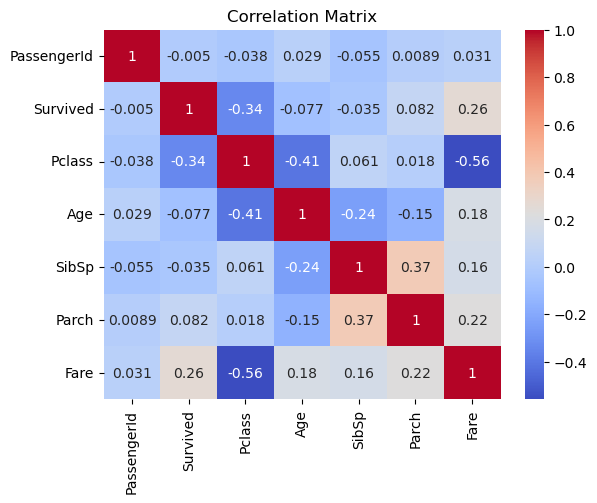

In [199]:
sns.heatmap(merged_data.corr(numeric_only=True), annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')

In [200]:
merged_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [201]:
merged_data.loc[:,train_data.isna().mean() != 0].isna().mean()

Age         0.200917
Cabin       0.774637
Embarked    0.001528
dtype: float64

From the above analysis, it looks like we have a couple of points to note:

**1.** We have four columns that contain object values, we will have to convert these to numerical values for our model to work. <br>

**2.** We have a number of missing values in the Age and Embark column, we will have to fill these in. <br>

**3.** We will have to determine if we need to drop the Cabin column, as 77% of these values are missing. <br>

**4.** Out of the columns that contain numerical values, the Pclass and Fare columns have a significant negative correlation with the Survived column. <br>

Next, lets take a look at some visualizations to get a better understanding of the data.

Text(0.5, 1.0, 'Survival rate by Embarked')

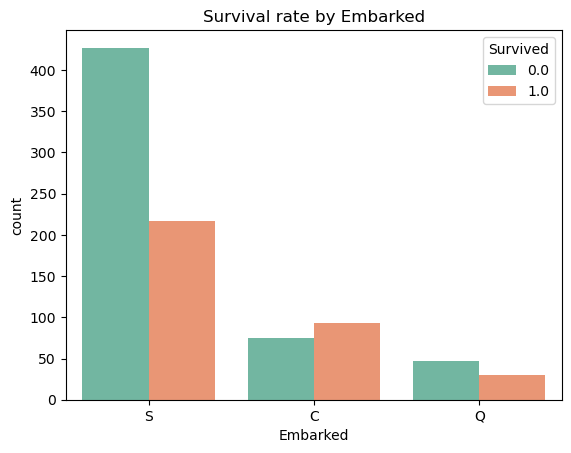

In [202]:
sns.countplot(x='Embarked', hue='Survived', data=merged_data, palette='Set2')
plt.title('Survival rate by Embarked')

In [203]:
merged_data.groupby(['Embarked']).mean(numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Embarked,,,,,,,
C,690.655556,0.553571,1.851852,32.332170,0.400000,0.370370,62.336267
Q,668.593496,0.389610,2.894309,28.630000,0.341463,0.113821,12.409012
S,643.095186,0.336957,2.347921,29.245205,0.550328,0.426696,27.418824


Since the Sibsp (Sibling/Spouse) and Parch (Parent/Child) columns are related, we will combine them into a new column called Family. This will give us a better idea of how many family members each passenger had on board.

In [204]:
merged_data['Family_Size'] = merged_data['SibSp'] + merged_data['Parch'] + 1

<Axes: xlabel='Survived', ylabel='Family_Size'>

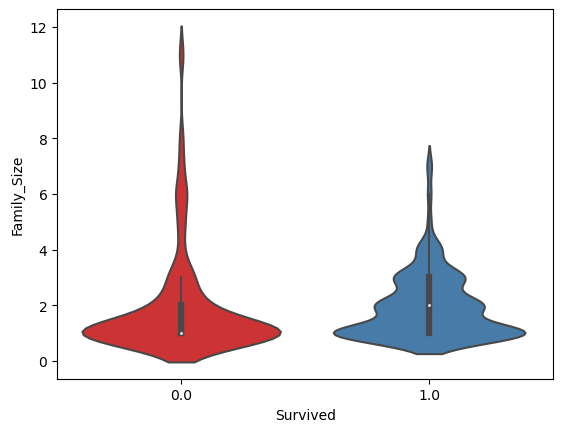

In [205]:
sns.violinplot(x='Survived', y='Family_Size', data=merged_data, palette='Set1')

<h3> Data Cleaning </h3>

Now that we have a better understanding of the data, we can start cleaning it up. We will start by filling in the missing values in the Age and Embarked columns. For the Age column, we will fill in the missing values with a random age based on the mean and standard deviation of the ages given in the dataset. For the Embarked column, we will fill in the missing values with the most common port of embarkation.

In [206]:
def random_age(x):
    '''
    This function calculates missing age values by randomly choosing an age value between the mean and standard deviation of the age column
    Parameters:
    x (df): the dataframe

    Returns:
    float: The age value
    '''
    if pd.isnull(x['Age']):
        lower_bound = merged_data['Age'].mean() - merged_data['Age'].std()
        upper_bound = merged_data['Age'].mean() + merged_data['Age'].std()
        return np.random.randint(lower_bound, upper_bound)
    else:
        return x['Age']


In [207]:
merged_data['Age'] = merged_data.apply(random_age, axis=1)

In [208]:
embarked_most_freq = merged_data['Embarked'].value_counts().index[0]
merged_data['Embarked'] = merged_data['Embarked'].fillna(embarked_most_freq)


For the cabin column, the data consits of a letter and a number. The letter refers to what level of the ship the cabin was located. We can make a new column called "Level" and only include the letter in the column. We will also fill in the missing values with "Unknown".

In [209]:
def ship_level(x):
    '''
    This function cleans the cabin column by extracting the first letter of the cabin number. If the cabin number is missing, it is replaced with 'Unknown'
    Parameters:
    x (df): the dataframe

    Returns:
    str: The cabin letter
    '''
    if pd.isnull(x['Cabin']):
        return 'Unknown'
    elif 'A' in x['Cabin']:
        return 'A'
    elif 'B' in x['Cabin']:
        return 'B'
    elif 'C' in x['Cabin']:
        return 'C'
    elif 'D' in x['Cabin']:
        return 'D'
    elif 'E' in x['Cabin']:
        return 'E'
    elif 'F' in x['Cabin']:
        return 'F'
    else:
        return 'G'

In [210]:
merged_data['Level'] = merged_data.apply(ship_level, axis=1)


After succesfully filtering cabin levels into a new column, we can drop the original cabin column.

In [211]:
merged_data = merged_data.drop(['Cabin'], axis=1)


From our exploratory data analysis we can see that the ticjet column has a lot of unique values. We can drop this column as well.

In [212]:
merged_data = merged_data.drop(['Ticket'], axis=1)

For the names column, we can extract the title from each name and create a new column called "Title". We can then drop the original names column.

In [213]:
merged_data['Title'] = merged_data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]


In [214]:
merged_data['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

We can filter the Title column to only include the most common titles. We can then replace the uncommon titles with "Other".

In [215]:
def title_group(x):
    '''
    This function groups the titles into 4 categories: Mr, Mrs, Miss and Other
    Parameters:
    x (df): the dataframe

    Returns:
    str: The title group
    '''
    if x['Title'] in ['Mr', 'Mrs', 'Miss', 'Master']:
        return x['Title']
    else:
        return 'Other'

In [216]:
merged_data['Title'] = merged_data.apply(title_group, axis=1)
merged_data['Title'].value_counts()
merged_data = merged_data.drop(['Name'], axis=1)

There was one missing value in the Fare column, we can fill this in with the mean fare.

In [217]:
merged_data['Fare'] = merged_data['Fare'].fillna(merged_data['Fare'].mean())

Lets categorize the Age column into 5 categories: Child, Teen, Young Adult, Adult, and Senior.

In [218]:
def age_group(x):
    '''
    This function groups the age into 4 categories: Child, Teen, Young Adult, Adult and Senior
    Parameters:
    x (df): the dataframe

    Returns:
    str: The age group
    '''
    if x['Age'] < 13:
        return 'Child'
    elif x['Age'] < 20:
        return 'Teen'
    elif x['Age'] < 30:
        return 'Young Adult'
    elif x['Age'] < 60:
        return 'Adult'
    else:
        return 'Senior'

In [219]:
merged_data['Age_Group'] = merged_data.apply(age_group, axis=1)


We can also categorize the Fare column into 4 categories: Low, Average, Above Average, and High.

In [220]:
def fare_group(x):
    '''
    This function groups the fare into 4 categories: 0-8, 8-15, 15-31, 31+
    Parameters:
    x (df): the dataframe

    Returns:
    str: The fare group
    '''
    if x['Fare'] <= 8:
        return 'Low'
    elif x['Fare'] <= 15:
        return 'Average'
    elif x['Fare'] <= 31:
        return 'Above Average'
    else:
        return 'High'

In [221]:
merged_data['Fare_Group'] = merged_data.apply(fare_group, axis=1)

We will drop the PassengerId column as it does not provide any useful information.

In [223]:
merged_data = merged_data.drop(['PassengerId'], axis=1) 